In [1]:
import datetime 
import urllib, re, math
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.linear_model import LinearRegression
# change plot size
plt.rcParams['figure.dpi'] = 200
# change max number of rows to show
pd.set_option('display.max_rows', 300)

try:
    from packaging import version
except ImportError:
    !pip install packaging

if( version.parse(pd.__version__) < version.parse("0.23.4")):
    print("update pandas")
    !pip install pandas --upgrade #--ignore-installed
    print(version.parse(pd.__version__))
#might need this
#!pip install --upgrade pip    

In [66]:
# real time data, from a spin of JHU
# --> http://blog.lazd.net/coronadatascraper/
df = pd.read_csv("http://blog.lazd.net/coronadatascraper/data.csv",parse_dates=True)
df =df.set_index(["city","county","state","country"])
df.iloc[-1]


idx = pd.IndexSlice
# must have colons liberally used, firt two colons for city/county and last colon for all columns
#option 1 for access
df.loc[(np.nan, "Los Angeles County", "CA", "USA")]
#option 2 for access, using idx must have colons liberally used, firt two colons for city/county and last colon for all columns
df.loc[idx[:, "San Diego County", "CA", "USA"],:]
IClmns= idx["cases","death","recovered","tested"]

df.loc[idx[:, :, "CA", "USA"],IClmns]
ctrMask = df["cases"] > 1000
df.loc[idx[:, :, :, ctrMask],IClmns]

cases  death  recovered  tested
city county         state     country                                      
NaN  NaN            NaN       Germany        3675    NaN       46.0     NaN
                              Italy         17660    NaN     1439.0     NaN
                              Spain          5232    NaN      193.0     NaN
                              Switzerland    1139    NaN        4.0     NaN
                    Hubei     China         67786    NaN    51553.0     NaN
                    NaN       Iran          11364    NaN     2959.0     NaN
                              Korea, South   7979    NaN      510.0     NaN
                    Guangdong China          1356    NaN     1296.0     NaN
                    Henan     China          1273    NaN     1249.0     NaN
                    Zhejiang  China          1215    NaN     1197.0     NaN
                    Hunan     China          1018    NaN     1005.0     NaN
     Emilia Romagna NaN       ITA            2263    NaN       51.0     NaN
     Lombardia      NaN       ITA            9820    NaN     1198.0     NaN
     Veneto         NaN       ITA            1595    NaN      100.0     NaN

In [3]:
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
#      "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

files = ["time_series_19-covid-Confirmed.csv","time_series_19-covid-Deaths.csv","time_series_19-covid-Recovered.csv"]
file = files[0]
link =URL+file


#read csv can read urls directly
df = pd.read_csv(link,parse_dates=True)
# set row indices, only have dates for columns ids
df =df.set_index(["Country/Region","Lat","Long","Province/State"])

dt = df.columns[-1]
print(dt)
if sum(df[dt].apply(math.isnan)):
    print("missing samples go back one day")
    data = df.drop(columns=dt)
else:
    data = df
#create a no china row, all china and all US

#create a no china row, all china and all US
noChin = data.index.levels[0][data.index.levels[0]!="China"]
print(noChin)
data.loc["NoChina",np.NaN,np.NaN,np.NaN]=data.loc[(noChin)].sum()    

# note this is an over-estimate
data.loc[("USAll",np.NaN,np.NaN,np.NaN)]=data.loc["US"].sum()    

data.loc[("ChinaAll",np.NaN,np.NaN,np.NaN)]=data.loc["China"].sum()  

3/13/20
Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       ...
       'Taiwan*', 'Thailand', 'Togo', 'Tunisia', 'Turkey', 'US', 'Ukraine',
       'United Arab Emirates', 'United Kingdom', 'Vietnam'],
      dtype='object', name='Country/Region', length=124)


In [4]:
# usa has a problem cities and states overlap
usStates="""
Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming
"""

US = usStates.split('\n')[1:-1]
#data.loc[(US)]
sp.size(US)
#usStates.split('\n')[1:-1]
#US = list(set(data.index.levels[3])&set(US))
print(data.loc[("US",slice(None),slice(None),US)].sum()[-1])
print(data.loc["US"].sum()[-1])
#data.filter(like=',',axis=0)
#data.loc["US"]
#data.loc["US"]
#data.loc[("US",slice(None),slice(None), lambda df.: df.index.levels[3].str.contains(','))]


2102
2179


In [5]:


# create new groups
# dont use string for UR, but the 50 states
euro      = ["Germany","DenMark","France","Italy","Sweden","Switzerland",
             "Spain","Portugal","Belgium","Iceland","Ireland","Netherlands"]
northAmer = ["US","Canada","Mexico"],
asia      = ["South Korea","Taiwan","Japan"]   
middleEast=["Iraq","Egypt","Iran"]
countries={ "NoChina":"NoChina",
            "North America":northAmer,
            "Euro":euro,            
            "middle east":middleEast,
            "China":"China",
            "South Korea":"South Korea",
            "Japan":"Japan",
            "Italy":"Italy",            
            "South Korea":"Korea, South",
            "US":"US"}


In [6]:

#data.loc["Italy"][dt]
data[dt]# get last row
data[data[dt]>800].sort_values("Country/Region").iloc[:,-5:]

3/9/20  3/10/20  3/11/20  \
Country/Region Lat     Long      Province/State                             
China          27.6140  115.7221 Jiangxi            935      935      935   
               31.8257  117.2264 Anhui              990      990      990   
               27.6104  111.7088 Hunan             1018     1018     1018   
               29.1832  120.0934 Zhejiang          1215     1215     1215   
               33.8820  113.6140 Henan             1272     1272     1273   
               30.9756  112.2707 Hubei            67743    67760    67773   
               23.3417  113.4244 Guangdong         1352     1353     1356   
ChinaAll       NaN     NaN       NaN              80860    80887    80921   
Denmark        56.2639  9.5018   Denmark             90      262      442   
France         46.2276  2.2137   France            1209     1784     2281   
Germany        51.0000  9.0000   NaN               1176     1457     1908   
Iran           32.0000  53.0000  NaN               7161     8042     9000   
Italy          43.0000  12.0000  NaN               9172    10149    12462   
Korea, South   36.0000  128.0000 NaN               7478     7513     7755   
Netherlands    52.1326  5.2913   NaN                321      382      503   
NoChina        NaN     NaN       NaN              32701    37705    44944   
Norway         60.4720  8.4689   NaN                205      400      598   
Spain          40.0000 -4.0000   NaN               1073     1695     2277   
Sweden         63.0000  16.0000  NaN                248      355      500   
Switzerland    46.8182  8.2275   NaN                374      491      652   
USAll          NaN     NaN       NaN                583      959     1281   

                                                 3/12/20  3/13/20  
Country/Region Lat     Long      Province/State                    
China          27.6140  115.7221 Jiangxi             935      935  
               31.8257  117.2264 Anhui               990      990  
               27.6104  111.7088 Hunan              1018     1018  
               29.1832  120.0934 Zhejiang           1215     1215  
               33.8820  113.6140 Henan              1273     1273  
               30.9756  112.2707 Hubei             67781    67786  
               23.3417  113.4244 Guangdong          1356     1356  
ChinaAll       NaN     NaN       NaN               80932    80945  
Denmark        56.2639  9.5018   Denmark             615      801  
France         46.2276  2.2137   France             2281     3661  
Germany        51.0000  9.0000   NaN                2078     3675  
Iran           32.0000  53.0000  NaN               10075    11364  
Italy          43.0000  12.0000  NaN               12462    17660  
Korea, South   36.0000  128.0000 NaN                7869     7979  
Netherlands    52.1326  5.2913   NaN                 503      804  
NoChina        NaN     NaN       NaN               47411    64248  
Norway         60.4720  8.4689   NaN                 702      996  
Spain          40.0000 -4.0000   NaN                2277     5232  
Sweden         63.0000  16.0000  NaN                 599      814  
Switzerland    46.8182  8.2275   NaN                 652     1139  
USAll          NaN     NaN       NaN                1663     2179

Growth Rate NoChina:1.16
Growth Rate China:1.07


<Figure size 432x288 with 0 Axes>

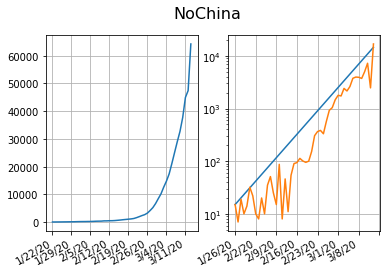

<Figure size 432x288 with 0 Axes>

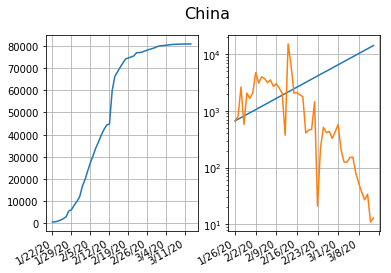

In [7]:
#assume (1+E*P) is 120%
import matplotlib.ticker as mticker

myLocator = mticker.MultipleLocator(7)

#determine slope and plot
for name in ["NoChina","China"]:
    ctr = countries[name]
    plt.figure()
    vals= data.loc[ctr].sum().diff()
    idx = np.argwhere(vals>0)[3][0]

    #print(idx)
    vals = vals[idx:]
    lv = sp.log10(vals)
    m=(max(lv)-lv[0])/(sp.size(lv))

    print("Growth Rate %s:%.2f"%(ctr,math.pow(10,m)))
    #print()
    
    fig, ax = plt.subplots(1,2)
    #---
    ax[1].plot(vals.index,pow(10,np.arange(0,sp.size(lv))*m+lv[0]))
    ax[1].semilogy(vals)
    
    ax[1].xaxis.set_major_locator(myLocator)
    ax[1].grid()
    fig.autofmt_xdate()
    
    #---
    ax[0].plot(data.loc[ctr].sum())        
    ax[0].xaxis.set_major_locator(myLocator)
    ax[0].grid()
    fig.autofmt_xdate()
    
    fig.suptitle('%s'% name, fontsize=16)


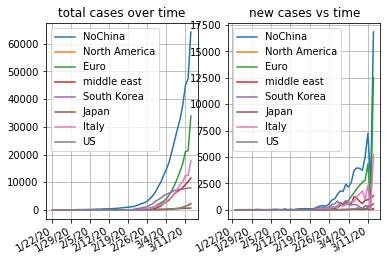

In [8]:
#ignore china here
fig, ax =plt.subplots(1,2)
for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    ax[0].plot(data.loc[(country)].sum(),label=name)
ax[0].xaxis.set_major_locator(myLocator)
ax[0].grid()
ax[0].legend()
ax[0].set_title("total cases over time");


for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    
    vals= data.loc[(country)].sum().diff()
    ax[1].plot(vals,label=name)
ax[1].xaxis.set_major_locator(myLocator)
ax[1].grid()
fig.autofmt_xdate()

ax[1].legend()
ax[1].set_title("new cases vs time");

# Smarter  model

Y' = A * sech^2( B * (t-C) )

Y = A/B * ( tanh( B * (t-C)) + 1 )

[ The equation for Y is just the integral of the equation for Y', where I have set the constant of integration to make the curve start at zero cases so far. ]


A = the peak infection rate (4600 case/day)

B = the width parameter (0.116)

C = the center date (2/6/2020 3AM)

sech z = 1/cosh z

       = 2/(e^z+e^-z)


 
# references

franklin antonio

https://royalsocietypublishing.org/doi/pdf/10.1098/rspa.1927.0118

 

The Epidemic Curve parts I & II, Wilson & Burke, 1942,1943

Proc Natl Acad Sci U S A. 1942 Sep; 28(9): 361–367

Proc Natl Acad Sci U S A. 1943 Jan; 29(1): 43–48

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078491/pdf/pnas01644-0025.pdf

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078553/pdf/pnas01648-0050.pdf


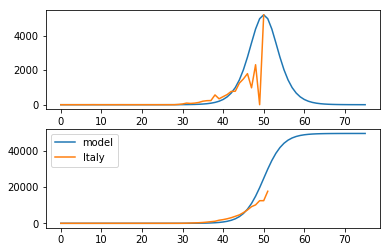

In [99]:

filtV= "South Korea"
#filtV= "China"

#filtV = "US"
filtV = "Italy"
#filtV = "China"
for ctr in countries.keys():
    #only get filtered country or group, from countries dict
    if not filtV == ctr: continue
    
    # get daily change, drop first value, '0'
    Nd = data.loc[countries[ctr]].sum().diff().values[1:]
    
    A=max(Nd)
    # this is width variable, smaller means slower groth (this is a guss)
    # first run wiht a good set then adjust to target (for example run with south kora)
    B=0.21 

    C=np.argmax(Nd)

    # must be in days

    t = np.arange(0,sp.size(Nd)+25)
    fig, ax = plt.subplots(2,1,)
    ax[0].plot(A/(np.cosh( B * (t-C))**2),label="model")
    ax[0].plot(Nd,label=ctr)
    ax[1].grid()
    ax[1].plot(A/B * ( np.tanh( B * (t-C)) + 1 ),label="model")
    ax[1].plot(data.loc[countries[ctr]].sum().values,label=ctr)
    ax[1].grid()
    plt.legend()
    #plt.title("total cases over time");


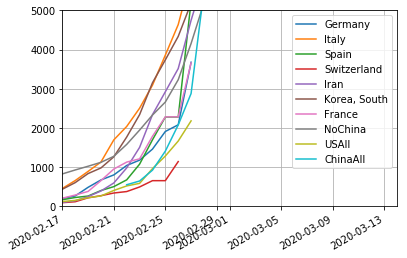

In [104]:
#align countries, with the following offset to get a prediction where they are 
# ideally normalize too
offsets = {"ChinaAll":31,
           "Italy":-9,
           "Spain":-15,
           "Iran":-8,
           "Germany":-15,
           "Korea, South":-5,
           "Switzerland":-16,
           "France":-15,
           "NoChina":0,
           "USAll":-15}
fig, ax=plt.subplots(1,1)
for index, row in data[data[dt]>1000].iterrows():
    ctr =index[0]
    #print(ctr)
    if("China" == ctr): continue
    
    vdt = [(datetime.datetime.strptime(d,"%m/%d/%y") +datetime.timedelta(days=offsets[ctr])).date()#.strftime("%m/%d")
           for d in data.columns]
    
    ax.plot(vdt,row.values, label=ctr)
#ax.xaxis.set_major_locator(myLocator)
ax.grid()
#control range to zoom regio of interest
ax.set_ylim(0, 5000)
ax.set_xlim(datetime.date(2020, 2, 17), datetime.date.today())
plt.legend()

fig.autofmt_xdate()



In [ ]:
# assuming a groth rate of 10%
#where will the us be
#start date
rate      = .12
startDate ="2/1/20"
ctr       = "US"
TN        = 15     # number of intervals after today
N  = sp.size(data.columns)
Y0 = data[startDate][ctr].sum()
offset = [i for i in range(0,sp.size(data.columns)) if data.columns[i] ==startDate][0]
Yt =Y0 * sp.exp(rate * np.arange(0,N-offset + TN))




plt.plot(np.arange(offset,N+TN),Yt,label="model")
plt.plot(data.loc[ctr].sum().values,label="actual")
plt.legend()

# using a growth rate of of 10%, assuming we are better then NoChina:1.14, given outlier of iran/italy
#today us has 1200, by monday we will have
1200 * np.exp(.1 * 3)

{'02/15/20': 165.0,
 '02/16/20': 186.036980510597,
 '02/17/20': 209.7561098030318,
 '02/18/20': 236.4993534024561,
 '02/19/20': 266.65227636182743,
 '02/20/20': 300.64960206443396,
 '02/21/20': 338.98147975624147,
 '02/22/20': 382.2005511688801,
 '02/23/20': 430.9299181148144,
 '02/24/20': 485.8721259258115,
 '02/25/20': 547.8192922515303,
 '02/26/20': 617.6645272480422,
 '02/27/20': 696.4148098044311,
 '02/28/20': 785.205505447746,
 '02/29/20': 885.3167352351257,
 '03/01/20': 998.1918316281359,
 '03/02/20': 1125.4581474329736,
 '03/03/20': 1268.9505178150346,
 '03/04/20': 1430.7377136464702,
 '03/05/20': 1613.1522675722692,
 '03/06/20': 1818.8241028058642,
 '03/07/20': 2050.718449490295,
 '03/08/20': 2312.178595276045,
 '03/09/20': 2606.9740864629653,
 '03/10/20': 2939.3550746360124,
 '03/11/20': 3314.1135923259653,
 '03/12/20': 3736.6526411239406,
 '03/13/20': 4213.064088313,
 '03/14/20': 4750.216495075041,
 '03/15/20': 5355.854142517526,
 '03/16/20': 6038.708683206865,
 '03/17/20': 

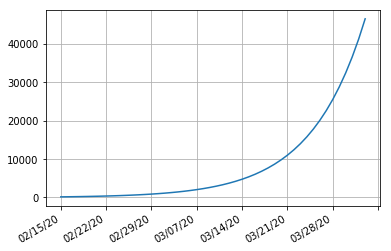

In [85]:
#using cdc data direclty
v = [int(t) for t in "0	0	2	0	1	0	0	0	1	1	1	0	1	3	0	0	2	1	1	0	1	1	0	0	0	1	0	1	0	3	1	1	3	2	0	0	5	10	6	7	11	14	13	34	16	30	19	40	40	53	51	48	58	74	43	79	46	50	15	2	0".split("\t")]
#but last week has been under report, so drop those samples
startDate = datetime.datetime(2020,2,15)

ss=36
ee=-8
y = np.add.accumulate(v)[ss:ee]
v = v[ss:ee]
today    = datetime.datetime.today()
N  = (today-startDate).days
#project for another 2 week
NP = 20
#start from scratch take y[0] and assume 10% groth and assume, y0 was 20% reported
yh = y[0] * 5 * np.exp(.12 * np.arange(0,N+NP))
x = [(startDate+datetime.timedelta(days=int(i))).strftime("%m/%d/%y") for i in np.arange(0,N+NP)]
fig, ax = plt.subplots(1,1)
plt.plot(x,yh)
ax.xaxis.set_major_locator(myLocator)
ax.grid()
fig.autofmt_xdate()
dict(zip(x,yh))


